In [1]:
import numpy as np

In [2]:
import PIL
from PIL import Image

In [3]:
import matplotlib

In [4]:
import os
import random
import copy
from os import listdir
from collections import defaultdict

In [5]:
def load_data(data_dir="./aligned/"):
    """ Load all PNG images stored in your data directory into a list of NumPy
        arrays.

    Args:
    data_dir: The relative directory path to the CompCar image directory.
    Returns:
        images: A dictionary with keys as car types and a list containing images associated with each key.
        cnt: A dictionary that stores the # of images in each car type
    """
    images = defaultdict(list)

    # Get the list of car type directory:
    for e in listdir(data_dir):
        # excluding any non-directory files
        if not os.path.isdir(os.path.join(data_dir, e)):
            continue
        # Get the list of image file names
        all_files = listdir(os.path.join(data_dir, e))

        for file in all_files:
            # Load only image files as PIL images and convert to NumPy arrays
            if '.jpg' in file:
                img = Image.open(os.path.join(data_dir, e, file))
                images[e].append(np.array(img))

    print("Car types: {} \n".format(list(images.keys())))

    cnt = defaultdict(int)
    for e in images.keys():
        print("{}: {} # of images".format(e, len(images[e])))
        cnt[e] = len(images[e])
    return images, cnt


In [6]:
# this function takes in all the img from all set and return a list of sets of mutually exclusive images and its labels.
def k_fold(imgs, k):
    res = []
    for _ in range(k):
        res.append(defaultdict(list))
    for key in imgs.keys():
        for i, entry in enumerate(imgs[key]):
            res[i%k][key].append(entry)
    return res

In [7]:
def PCA(X, n_components):

    """Args:
        X: has shape Mxd where M is the number of images and d is the dimension of each image
        n_components: The number of components you want to project your image onto. 
    
    Returns:
        projected: projected data of shape M x n_components
        mean_image: mean of all images
        top_sqrt_eigen_values: singular values
        top_eigen_vectors: eigenvectors 
    """
    mean_image = np.average(X, axis = 0)

    msd = X - mean_image # M x d

    smart_cov_matrix = np.matmul(msd, msd.T)
    eigen_values, smart_eigen_vectors = np.linalg.eig(smart_cov_matrix)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    smart_eigen_vectors = smart_eigen_vectors[:,idx]

    eigen_vectors = (np.matmul(msd.T, smart_eigen_vectors)).T # M x d

    row_norm = np.sum(np.abs(eigen_vectors)**2,axis=-1)**(1./2) # M

    normalized_eigen_vectors = eigen_vectors/(row_norm.reshape(-1, 1)) # M x d

    top_eigen_vectors = normalized_eigen_vectors[:n_components].T
    top_sqrt_eigen_values = np.sqrt(eigen_values[:n_components])

    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

    return projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors

In [8]:
def train(epoch = 5, fold = 10):
    img, cnt = load_data()
    folds = k_flod(img, fold)
    for foldIdx in range(fold):
        test, validation = folds[foldIdx], folds[(foldIdx + 1)%fold]
        train = defaultdict(list)
        for trainLoaderIter in range(2, fold):
            train.update(folds[(trainLoaderIter + foldIdx) % fold])
    pass

In [9]:
img, cnt = load_data()
folds = k_fold(img, 10)
test, validation = folds[0], folds[1]
train = defaultdict(list)
for trainLoaderIter in range(2, 10):
    for key in folds[trainLoaderIter].keys():
        train[key].extend(folds[trainLoaderIter][key])
totalTrainingAmount = 0
for key in train.keys():
    totalTrainingAmount += len(train[key])

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


In [10]:
print(totalTrainingAmount)

477


In [11]:
trainedPCA = np.zeros((totalTrainingAmount, 60000))
i = 0
memo = {}
for key in train.keys():
    for idx, ele in enumerate(train[key]):
        trainedPCA[i] = ele.reshape(1, 60000)
        memo[i] = (key, idx)
        i += 1

In [227]:
projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(trainedPCA, 40)

In [228]:
print(projected.shape)
print(top_eigen_vectors.shape)
print(mean_image.shape)
print(projected[0])


(477, 40)
(60000, 40)
(60000,)
[ 0.04510089 -0.04175314 -0.03479379 -0.00720877 -0.00150093  0.00857038
  0.0040771  -0.06566832  0.0441931   0.19909961  0.03926748  0.01231698
  0.01362904  0.01023256  0.03800397  0.07298338 -0.09157195  0.00737967
 -0.09481553 -0.00293754 -0.09325882  0.00291712  0.03690154 -0.04924077
  0.03345896 -0.05733611  0.03374892  0.0405336  -0.05676917  0.02726277
  0.0338387   0.11010176  0.02041617  0.07237279  0.00598181  0.04742183
 -0.03531657 -0.03748258 -0.07280348 -0.04743897]


In [229]:
np.matmul((trainedPCA[0] - mean_image), top_eigen_vectors)/top_sqrt_eigen_values

array([ 0.04510089, -0.04175314, -0.03479379, -0.00720877, -0.00150093,
        0.00857038,  0.0040771 , -0.06566832,  0.0441931 ,  0.19909961,
        0.03926748,  0.01231698,  0.01362904,  0.01023256,  0.03800397,
        0.07298338, -0.09157195,  0.00737967, -0.09481553, -0.00293754,
       -0.09325882,  0.00291712,  0.03690154, -0.04924077,  0.03345896,
       -0.05733611,  0.03374892,  0.0405336 , -0.05676917,  0.02726277,
        0.0338387 ,  0.11010176,  0.02041617,  0.07237279,  0.00598181,
        0.04742183, -0.03531657, -0.03748258, -0.07280348, -0.04743897])

In [230]:
print(top_sqrt_eigen_values)

[124548.04784268 117856.75883741  95302.74571461  74209.61304212
  64263.02375421  59189.87832571  57436.53582108  55454.05437636
  49108.38380807  44997.10890241  44284.50273729  43329.57507516
  40108.78741917  38919.13465665  38047.02961537  35839.35800018
  34743.96717512  33395.77700687  32672.15073757  31603.39230473
  30910.40668837  30082.55744989  29442.83946063  28394.7507638
  28312.08699126  27205.90675152  27067.56531158  26041.04961542
  25972.23632386  25286.7599597   24786.90914618  24406.77525212
  24005.76792753  23766.02518787  23471.74650259  23198.06041658
  23124.6541963   22636.21798318  22290.11799254  22083.23370062]


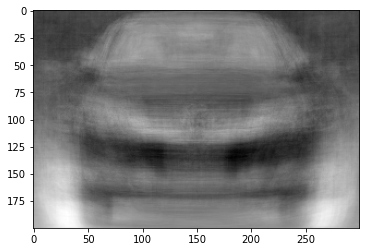

In [231]:
imgArr = (top_eigen_vectors.T)[3].reshape(200, 300)
imgArr += imgArr.min()
imgArr *= 255.0/imgArr.max()
img = plt.imshow(imgArr, cmap='gray')

In [236]:

#(a) Implement Logistic Regression via Gradient Descent. (5 points)
#Now, without using any high-level machine learning libraries, implement logistic regression. Here, you’ll be using batch gradient descent, and will only need one logistic output unit. (Think about why we only need one if we’re classifying two classes?) The most points will be given for clean, well-documented code.

def gradient_descent(X, y, lr=0.05, epoch=300):
    '''
    Gradient Descent for a single feature
    X -> feature -> m * d
    y -> label -> m
    lr -> learning rate
    epoch -> epoch
    
    weights <-
    mse     <-
    '''
    
    weight = np.zeros((projected.shape[1]+1, 1))
    N = len(X) # number of samples
    log = []
    #log, mse = [], [] # lists to store learning process
    # M * (d+1)--> X with last be bias term (feature)
    # M * 1    --> y --> lable
    
    for _ in range(epoch):
        errorSum = np.zeros((X.shape[1]+1, 1))
        biasIncludedX = np.append(X, np.ones((X.shape[0], 1)), 1)
        calculatedTarget = biasIncludedX@weight
        
        diffs = (y - calculatedTarget)
        #print(diffs.shape, y.shape, calculatedTarget.shape)
        for i, diff in enumerate(diffs):
            #print(diff.shape, errorSum.shape, X[i].shape)
            errorSum += diff[0] * np.append(X[i], [1]).reshape((X.shape[1]+1, 1))
        
        weight += errorSum * lr * (1/N)
        log.append(sum(diffs**2)[0])

    return weight, log

In [237]:
#newTrainingMiniVan = train['Minivan']
#newTrainingConvertable = train['Convertible']
y = []
X = []
for i in range(len(memo)):
    if memo[i][0] == 'Convertible':
        y.append(0)
        X.append(projected[i])
    elif memo[i][0] == 'Minivan':
        y.append(1)
        X.append(projected[i])
X = np.array(X)
y = np.array(y).reshape(1, len(y)).T

In [238]:
print(X.shape)
print(y.shape)

(237, 40)
(237, 1)


In [239]:
w, l = gradient_descent(X, y)
print(w)

[[ 0.01523646]
 [-0.00185151]
 [-0.04923986]
 [ 0.06515954]
 [ 0.06559333]
 [ 0.08221743]
 [ 0.06039351]
 [-0.09247577]
 [-0.11841567]
 [ 0.01859844]
 [ 0.02951207]
 [ 0.0334136 ]
 [-0.07161573]
 [ 0.05325835]
 [ 0.03154171]
 [ 0.04806025]
 [ 0.00260185]
 [ 0.00586648]
 [ 0.03765001]
 [ 0.04766653]
 [ 0.07372026]
 [-0.05048918]
 [ 0.02107621]
 [-0.02960383]
 [-0.0059419 ]
 [ 0.00404225]
 [-0.00232042]
 [ 0.01513378]
 [-0.02248648]
 [-0.01263281]
 [ 0.03846461]
 [ 0.00185718]
 [ 0.01939168]
 [ 0.04459707]
 [-0.04463625]
 [-0.02662875]
 [ 0.01958607]
 [ 0.06572622]
 [-0.01133   ]
 [ 0.03997317]
 [ 0.49805931]]


In [248]:
validationConvertable = test['Convertible']
validationMinivan     = test['Minivan']

validationPCAed = []
validationY = []
for i in range(len(validationConvertable)):
    validationPCAed.append((np.matmul(validationConvertable[i].reshape(1, 60000) - mean_image, top_eigen_vectors)/top_sqrt_eigen_values)[0])
    validationY.append(0)
for i in range(len(validationMinivan)):
    validationPCAed.append((np.matmul(validationMinivan[i].reshape(1, 60000) - mean_image, top_eigen_vectors)/top_sqrt_eigen_values)[0])
    validationY.append(1)

In [249]:
print(len(validationPCAed))
validationPCAed = np.array(validationPCAed)
print(validationPCAed.shape[0])

30
30


In [250]:
validationPCAed = np.append(validationPCAed, np.ones((validationPCAed.shape[0], 1)), 1)

In [251]:
validationPCAed@w

array([[ 1548.79075094],
       [  -73.21023935],
       [  869.6983421 ],
       [ -420.18773811],
       [ -579.91220279],
       [ -960.87552197],
       [ -242.14970009],
       [  218.11060597],
       [-1081.5970385 ],
       [  -84.40518568],
       [  757.93812314],
       [ 1150.96197106],
       [  504.47056164],
       [ -826.28006179],
       [ 1015.48453552],
       [-1010.73407959],
       [  -62.5404348 ],
       [ -452.41752344],
       [-1359.06221227],
       [ -902.81168926],
       [ -521.5811897 ],
       [ 1064.97404798],
       [  748.14893894],
       [  398.2824664 ],
       [-1101.09108203],
       [  101.60090686],
       [  587.09770372],
       [  145.26194165],
       [  956.29135782],
       [  448.65168845]])

In [214]:
validationPCAed

array([[[-0.03939948, -0.09901309,  0.01833142, -0.06271096]],

       [[-0.00414154,  0.01996479,  0.03190914, -0.02439031]],

       [[-0.04809855, -0.05167845, -0.05362545, -0.02996231]],

       [[ 0.01716265,  0.01120006, -0.0054657 , -0.10713878]],

       [[ 0.06211222, -0.0253725 , -0.00702256, -0.04552486]],

       [[ 0.12034243, -0.02510041, -0.04879969,  0.10757602]],

       [[ 0.00403788,  0.0238018 ,  0.0459504 , -0.00561836]],

       [[-0.05429617,  0.01416012,  0.0559872 , -0.05683737]],

       [[ 0.03444111,  0.0560334 ,  0.04331807,  0.00038817]],

       [[-0.02936933,  0.04216799, -0.00841457,  0.01815506]],

       [[-0.04206927, -0.02264358, -0.00945543,  0.04054792]],

       [[-0.03662373, -0.05848483,  0.0513842 ,  0.01333223]],

       [[-0.01876213, -0.01124949,  0.04187682, -0.00989503]],

       [[ 0.03797472,  0.02665159, -0.00722945, -0.09522296]],

       [[-0.06987096, -0.0278548 , -0.0039949 , -0.02979341]],

       [[ 0.09992834, -0.02340391, -0.06